# MPI–ORAS validation
Comparison between MPI climate model and ORAS5

## Imports

In [1]:
import warnings
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import numpy as np
import seaborn as sns
import xarray as xr
import tqdm
import pathlib
import cmocean
import pandas as pd
import os
import scipy.stats

# Import custom modules
from src.XRO import XRO, xcorr
import src.utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## bump up DPI
mpl.rcParams["figure.dpi"] = 100

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])
SAVE_FP = pathlib.Path(os.environ["SAVE_FP"])

## $T, h$ metrics

### Load data

In [2]:
## MPI data
mpi_load_fp = pathlib.Path(DATA_FP, "mpi_Th", "Th.nc")
Th_mpi = xr.open_dataset(mpi_load_fp)

## ORAS5 reanalysis (use as benchmark)
oras_load_fp = pathlib.Path(DATA_FP, "XRO_indices_oras5.nc")
Th_oras = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
Th_mpi = Th_mpi.sel(time=slice("1979", "2024"))
Th_oras = Th_oras[["Nino34", "WWV"]].rename({"Nino34": "T_34", "WWV": "h"})

### Diagnostics

#### Seasonal synchronization

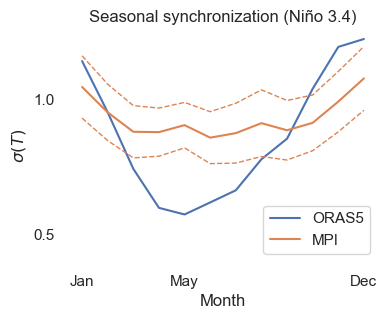

In [3]:
## specify which "T" variable to use for MPI
T_var_mpi = "T_34"

## func to compute std dev as a function of month
get_std = lambda x: x.groupby("time.month").std("time")

## compute std for each dataset
oras_std = get_std(Th_oras["T_34"])
mpi_std = get_std(Th_mpi[T_var_mpi])
mpi_std_plot = src.utils.get_ensemble_stats(mpi_std)

## months (x-coordinate for plotting
months = np.arange(1, 13)

### Set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot for ORAS5
oras_plot = ax.plot(months, oras_std, label="ORAS5")

## plot MPI ensemble mean
mpi_plot = ax.plot(months, mpi_std_plot.sel(posn="center"), label="MPI")

## plot MPI bounds
kwargs = dict(c=mpi_plot[0].get_color(), ls="--", lw=1)
for bound in ["upper", "lower"]:
    ax.plot(months, mpi_std_plot.sel(posn=bound), **kwargs)

## adjust limits and label
ax.set_ylim([0.4, None])
ax.set_yticks([0.5, 1])
ax.set_xticks([1, 5, 12], labels=["Jan", "May", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel(f"$\\sigma(T)$")
ax.set_title("Seasonal synchronization (Niño 3.4)")
ax.legend()
plt.show()

#### $T,h$ cross-correlation

Plotting funcs

In [4]:
def format_axs(axs):
    ## add axis lines to plots
    axis_kwargs = dict(c="k", lw=0.5, alpha=0.5)
    for ax in axs.flatten():
        ax.axhline(0, **axis_kwargs)
        ax.axvline(0, **axis_kwargs)
        ax.set_ylim([-0.7, 1.1])

    #### label plots

    ## bottom row
    for ax in axs[1]:
        ax.set_xlabel("Lag (years)")
        ax.set_xticks([-12, 0, 12], labels=[-1, 0, 1])

    ## top row
    for ax in axs[0]:
        ax.set_xticks([])

    ## left col
    for ax in axs[:, 0]:
        ax.set_ylabel("Correlation")

    ## right col
    for ax in axs[:, 1]:
        ax.set_yticks([])

    return axs


def plot_oras(ax, data, color, label=None):
    """Plot curve for oras"""

    ax.plot(data.lag, data, c=color, label=label, ls="--")

    return


def plot_mpi(ax, data, color, label=None):
    """plot mean and bounds for MPI"""

    ## center
    ax.plot(
        data.lag,
        data.sel(posn="center"),
        c=color,
        label=label,
    )

    ## bounds
    ax.fill_between(
        data.lag, data.sel(posn="upper"), data.sel(posn="lower"), color=color, alpha=0.2
    )

    return

Compute stats

In [5]:
## specify which "T" variable to use for MPI
T_var_mpi = "T_34"
h_var_mpi = "h"

## compute cross-correlation
xcorr_oras = xcorr(Th_oras, Th_oras["T_34"], maxlags=18)
xcorr_mpi = xcorr(Th_mpi, Th_mpi[T_var_mpi], maxlags=18)

## compute MPI stats
xcorr_mpi_stats = src.utils.get_ensemble_stats(xcorr_mpi)

Make plot

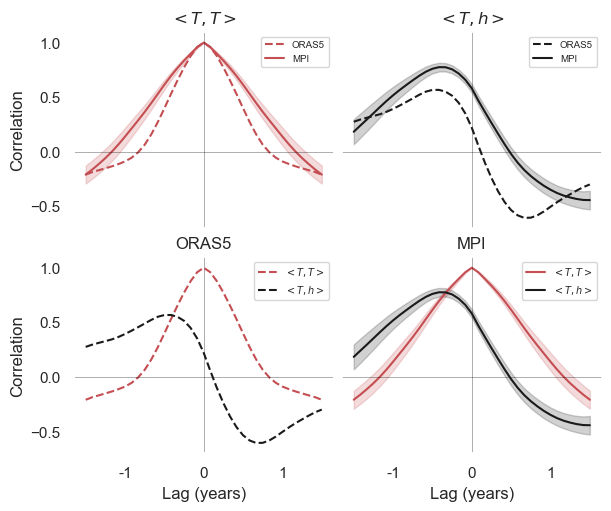

In [6]:
## specify plot properties for legend
legend_prop = dict(size=7)

fig, axs = plt.subplots(2, 2, figsize=(6, 5), layout="constrained")

## plot <T,T>
axs[0, 0].set_title(r"$<T, T>$")
plot_oras(axs[0, 0], xcorr_oras["T_34"], color="r", label="ORAS5")
plot_mpi(axs[0, 0], xcorr_mpi_stats[T_var_mpi], color="r", label="MPI")

## plot <T,h>
axs[0, 1].set_title(r"$<T, h>$")
plot_oras(axs[0, 1], xcorr_oras["h"], color="k", label="ORAS5")
plot_mpi(axs[0, 1], xcorr_mpi_stats[h_var_mpi], color="k", label="MPI")

## plot for ORAS5
axs[1, 0].set_title("ORAS5")
plot_oras(axs[1, 0], xcorr_oras["T_34"], color="r", label="$<T, T>$")
plot_oras(axs[1, 0], xcorr_oras["h"], color="k", label="$<T, h>$")

## plot for MPI
axs[1, 1].set_title("MPI")
plot_mpi(axs[1, 1], xcorr_mpi_stats[T_var_mpi], color="r", label="$<T, T>$")
plot_mpi(axs[1, 1], xcorr_mpi_stats[h_var_mpi], color="k", label="$<T, h>$")

## clean up axes
axs = format_axs(axs)

for ax in axs.flatten():
    ax.legend(prop=dict(size=7))

plt.show()

#### PDF / Skewness

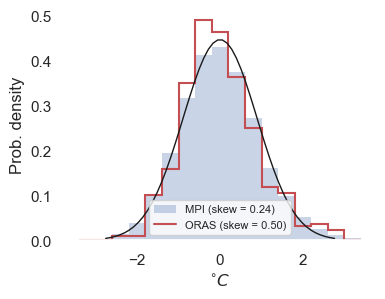

In [7]:
## select variables to compare
time_idx = dict(time=slice(None, None, None))
mpi_var = "T_34"
oras_var = "T_34"

## edges for PDF
edges = np.arange(-3.4, 3.8, 0.4)

## extract relevant data
x_mpi = Th_mpi[mpi_var].isel(time_idx).values.flatten()
x_oras = Th_oras[oras_var].isel(time_idx).values.flatten()

## compute and plot pdf
pdf_mpi, _ = src.utils.get_empirical_pdf(x_mpi, edges=edges)
pdf_oras, _ = src.utils.get_empirical_pdf(x_oras, edges=edges)

## compute skewness
skew_mpi = scipy.stats.skew(x_mpi)
skew_oras = scipy.stats.skew(x_oras)

## get gaussian best fit to obs.
pdf_gauss, pdf_gauss_pts = src.utils.get_gaussian_best_fit(x_oras)

## set up plot
fig, ax = plt.subplots(figsize=(4, 3))

## plot pdf
ax.stairs(pdf_mpi, edges, fill=True, alpha=0.3, label=f"MPI (skew = {skew_mpi:.2f})")
ax.stairs(pdf_oras, edges, color="r", lw=1.5, label=f"ORAS (skew = {skew_oras:.2f})")

## plot gaussian best fit
ax.plot(pdf_gauss_pts, pdf_gauss, c="k", lw=1)

## label
ax.legend(prop=dict(size=8))
ax.set_xlabel(r"$^{\circ}C$")
ax.set_ylabel("Prob. density")

plt.show()

### RO-based diagnostics
Note: need to non-dimensionalize $T$ and $h$ data to compare $F_1$ and $F_2$ parameters to each other and to $R$ and $\epsilon$

In [8]:
## get non-dimensional scale for each variable (specific to each dataset)
scale_oras = Th_oras.std()
scale_mpi = Th_mpi.std()

## non-dimensionalize
Th_oras_nondim = Th_oras / scale_oras
Th_mpi_nondim = Th_mpi / scale_mpi

In [9]:
def plot_param_ensemble(ax, param, label=None):
    """plot ensemble of parameters on given ax object"""

    ## specify plot style for ensemble mean v. members
    mean_kwargs = dict(c="k", lw=3, label=label)
    mem_kwargs = dict(c="k", lw=0.5, alpha=0.2)

    ## plot ensemble mean
    ax.plot(param.cycle, param.mean("member"), **mean_kwargs)

    ## plot individual members
    for m in param.member:
        ax.plot(param.cycle, param.sel(member=m), **mem_kwargs)

    return


def plot_param(ax, param, **plot_kwargs):
    """plot parameter on given ax object"""

    ax.plot(param.cycle, param, **plot_kwargs)


def label_ac_ax(ax):
    """add labels to growth rate annual cycle plot (ax object)"""

    ax.set_ylabel(r"Growth rate (yr$^{-1}$)")
    ax.axhline(0, c="k", ls="-", lw=0.5)
    ax.set_xticks([1, 8, 12], labels=["Jan", "Aug", "Dec"])

    return

#### Growth rate / periodicity

Do the computation

In [10]:
## specify T and h variables to use for MPI
T_var_mpi = "T_34"
h_var_mpi = "h"

## specify order of annual cycle
ac_order = 3

## specify which parameters to mask annual cycle out for [(y_idx0, x_idx0), ...]
ac_mask_idx = [(1, 1)]
# ac_mask_idx = None

## initialize model
model = XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit for reanalysis
fit_oras = model.fit_matrix(Th_oras_nondim[["T_34", "h"]], ac_mask_idx=ac_mask_idx)

## get fit for MPI (ensemble-of-RO method)
_, fit_mpi = src.utils.get_RO_ensemble(
    Th_mpi_nondim,
    model=model,
    T_var=T_var_mpi,
    h_var=h_var_mpi,
    ac_mask_idx=ac_mask_idx,
)

## get fit for MPI (ensemble fit)
fit_mpi_all = model.fit_matrix(
    Th_mpi_nondim[[T_var_mpi, h_var_mpi]],
    ac_mask_idx=ac_mask_idx,  # , maskNT=['T2', 'TH'],
)

## compute timescales for each
bj_oras, period_oras = src.utils.get_timescales(model, fit_oras)
bj_mpi, period_mpi = src.utils.get_timescales_ensemble(model, fit_mpi)
bj_mpi_all, period_mpi_all = src.utils.get_timescales(model, fit_mpi_all)

## get PDF for period
pdf, edges = src.utils.get_empirical_pdf(period_mpi, edges=np.arange(2, 8, 1 / 3))

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/computation.py:824: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


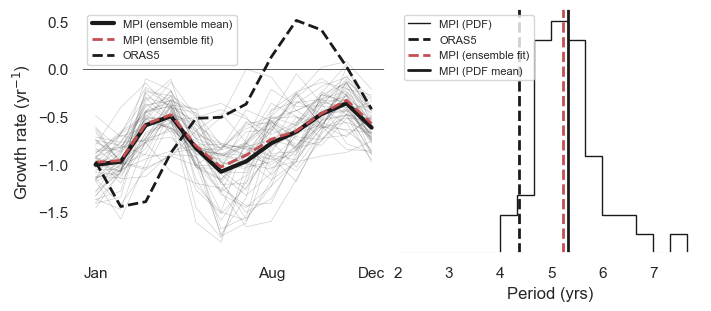

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), layout="constrained")

### plot seasonal cycle of growth rate
# MPI: ensemble and ensemble mean
plot_param_ensemble(axs[0], bj_mpi, label="MPI (ensemble mean)")

# MPI: fit to all ensemble members
plot_kwargs = dict(c="r", ls="--", lw=2, label="MPI (ensemble fit)")
plot_param(axs[0], bj_mpi_all, **plot_kwargs)

# ORAS5
plot_kwargs = dict(c="k", ls="--", lw=2, label="ORAS5")
plot_param(axs[0], bj_oras, **plot_kwargs)
axs[0].legend(prop=dict(size=8))

## label axes
label_ac_ax(axs[0])

## plot period
axs[1].stairs(pdf, edges, color="k", label="MPI (PDF)")
axs[1].axvline(period_oras, c="k", ls="--", lw=2, label="ORAS5")
axs[1].axvline(period_mpi_all, c="r", ls="--", lw=2, label="MPI (ensemble fit)")
axs[1].axvline(period_mpi.mean(), c="k", lw=2, label="MPI (PDF mean)")
axs[1].set_xlim([2, None])
axs[1].set_yticks([])
axs[1].set_xlabel("Period (yrs)")
axs[1].legend(prop=dict(size=8))

plt.show()

#### Parameters

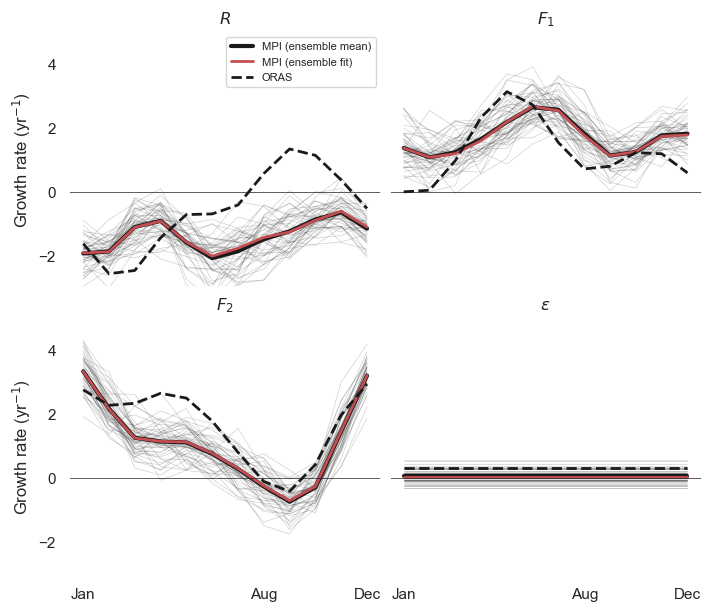

In [12]:
## Get parameters for ORAS and MPI
params_oras = model.get_RO_parameters(fit_oras)
params_mpi = model.get_RO_parameters(fit_mpi)
params_mpi_all = model.get_RO_parameters(fit_mpi_all)

## get labels of parameters for plotting
labels = [r"$R$", r"$F_1$", r"$F_2$", r"$\epsilon$"]
var_names = ["R", "F1", "F2", "epsilon"]

## set up plot
fig, axs = plt.subplots(2, 2, figsize=(7, 6), layout="constrained")

## separate plo for each set of parameters
for i, (ax, label, n) in enumerate(zip(axs.flatten(), labels, var_names)):

    ### plot seasonal cycle parameter for each
    plot_param_ensemble(ax, params_mpi[n], label="MPI (ensemble mean)")
    plot_param(ax, params_mpi_all[n], c="r", lw=2, label="MPI (ensemble fit)")
    plot_param(ax, params_oras[n], c="k", ls="--", lw=2, label="ORAS")
    ax.set_title(label)
    ax.set_ylim([-3, 5])
    label_ac_ax(ax)

## make plot less clustered
for ax in axs[0, :]:
    ax.set_xlabel(None)
    ax.set_xticks([])
for ax in axs[:, 1]:
    ax.set_ylabel(None)
    ax.set_yticks([])
for ax in axs[:, 0]:
    ax.set_yticks([-2, 0, 2, 4])

axs[0, 0].legend(prop=dict(size=8))
plt.show()

## Spatial data

#### Load ORAS5 data and compute anomalies

In [13]:
## specify filepaths
oras_sst_fp = pathlib.Path(DATA_FP, "oras5", "sst")
oras_ssh_fp = pathlib.Path(DATA_FP, "oras5", "ssh")

## load data
data_oras = src.utils.load_oras_spatial(oras_sst_fp, oras_ssh_fp)

## estimate forced signal by removing 2nd-order polynomial from each calendar month
detrend_fn = lambda x: src.utils.detrend_dim(x, dim="time", deg=2)
oras_anom = data_oras.groupby("time.month").map(detrend_fn)
oras_forced = data_oras - oras_anom

### Load MPI data and compute anomalies

In [14]:
## Load EOF data
eofs_fp = pathlib.Path(DATA_FP, "mpi", "eofs")
eofs_sst = src.utils.load_eofs(eofs_fp / "ts.nc")
eofs_ssh = src.utils.load_eofs(eofs_fp / "ssh.nc")

## for convenience, put PC data into single dataset
pc_data = xr.merge([eofs_sst.scores().rename("sst"), eofs_ssh.scores().rename("ssh")])

## trim to same period as ORAS
pc_data = pc_data.sel(time=slice("1979", "2018"))
pc_data["time"] = oras_anom.time

## estimate forced signal
forced = pc_data.mean("member")
anom = pc_data - forced

### Mean

#### Compute

In [15]:
## compute time-mean for ORAS
mean_oras = oras_forced.mean("time")

## compute time-mean for MPI
mean_mpi = forced.mean("time")
mean_mpi_spatial = xr.merge(
    [
        eofs_sst.inverse_transform(mean_mpi["sst"]).rename("sst"),
        eofs_ssh.inverse_transform(mean_mpi["ssh"]).rename("ssh"),
    ]
)

## interpolate to match ORAS grid
mean_mpi_spatial = mean_mpi_spatial.interp_like(mean_oras)

## compute absolute bias
bias = mean_mpi_spatial - mean_oras

#### Plot

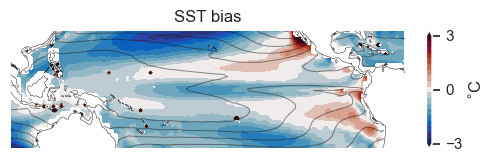

In [16]:
## get lon and lat for convenience
lon = mean_oras.longitude
lat = mean_oras.latitude

## specify plotting styles for bias and ground truth
bias_kwargs = dict(
    cmap="cmo.balance",
    levels=src.utils.make_cb_range(3, 0.3),
    transform=ccrs.PlateCarree(),
    extend="both",
    alpha=1,
)

truth_kwargs = dict(
    levels=10,
    transform=ccrs.PlateCarree(),
    extend="both",
    linewidths=0.7,
    colors="k",
    alpha=0.5,
)

## set up the plot
fig = plt.figure(figsize=(5, 1.5), layout="constrained")
ax = src.utils.plot_setup(fig, lon_range=[100, 300], lat_range=[-30, 30])
ax.set_title("SST bias")

## plot bias
plot_data = ax.contourf(lon, lat, bias["sst"], **bias_kwargs)
cb = fig.colorbar(plot_data, ticks=[-3, 0, 3], label=r"$^{\circ}$C")

## plot "true" mean state
plot_data = ax.contour(lon, lat, mean_oras["sst"], **truth_kwargs)

plt.show()

### Spatial variance

#### Compute

In [17]:
## subset for month if desired
months = None

## subset data
oras_anom_ = src.utils.sel_month(oras_anom, months)
anom_ = src.utils.sel_month(anom, months)

## compute for ORAS
var_oras = oras_anom_.var("time")

## compute for MPI
var_mpi = src.utils.reconstruct_var(anom_["sst"], eofs_sst.components()).compute()

## interpolate to same grid
var_mpi = var_mpi.interp_like(var_oras)

## compute bias
bias = var_mpi - var_oras

## compute "pattern bias" (normalize by variance in Niño 3.4 region)
# norm = lambda x : x / x.mean()
norm = lambda x: x / src.utils.get_nino34(x)
pattern_bias = np.sqrt(norm(var_mpi)) - np.sqrt(norm(var_oras))

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/core/nputils.py:242: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Function for paneled subplot

In [18]:
def make_variance_subplots(axs, show_colorbars):
    """make 3-paneled subplots showing variance in ORAS5 and MPI; and (normalized) difference)"""

    ## shared arguments
    kwargs = dict(cmap="cmo.amp", transform=ccrs.PlateCarree(), extend="both")

    ## plot variance in ORAS5
    plot_data0 = axs[0, 0].contourf(
        lon, lat, var_oras["sst"], levels=np.arange(0, 2.25, 0.25), **kwargs
    )
    axs[0, 0].set_title("ORAS5")

    ## plot variance in MPI
    plot_data1 = axs[1, 0].contourf(
        lon, lat, var_mpi, levels=np.arange(0, 1.1, 0.1), **kwargs
    )
    axs[1, 0].set_title("MPI")

    ## plot (normalized) difference
    kwargs.update(dict(cmap="cmo.balance", levels=src.utils.make_cb_range(0.7, 0.07)))
    plot_data2 = axs[2, 0].contourf(lon, lat, pattern_bias["sst"], **kwargs)
    axs[2, 0].set_title("Pattern bias")

    ## add colorbars if desired
    if show_colorbars:
        fig.colorbar(plot_data0, ax=axs[0, 0], ticks=[0, 1, 2])
        fig.colorbar(plot_data1, ax=axs[1, 0], ticks=[0, 0.5, 1])
        fig.colorbar(plot_data2, ax=axs[2, 0], ticks=[-0.7, 0, 0.7])

    return axs

#### Plot (large scale)

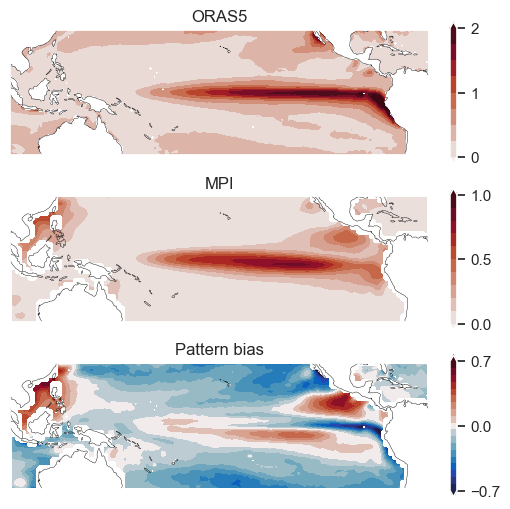

In [19]:
## set up paneled subplot
fig = plt.figure(figsize=(5, 5), layout="constrained")
axs = src.utils.subplots_with_proj(
    fig, nrows=3, ncols=1, format_func=src.utils.plot_setup_pac
)

## plot data
axs = make_variance_subplots(axs, show_colorbars=True)

plt.show()

#### Plot (zoom in on Niño regions)

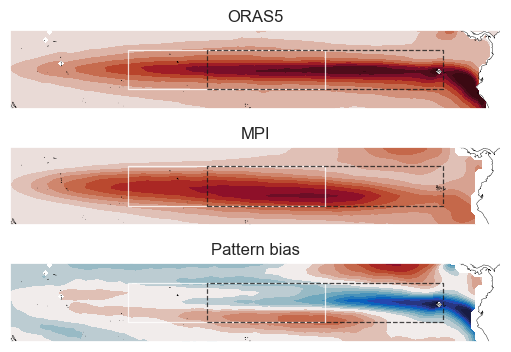

In [20]:
def plot_setup_zoom(ax):
    """Plot Pacific region"""

    ## trim and add coastlines
    ax.coastlines(linewidth=0.3)
    ax.set_extent([160, 285, -10, 10], crs=ccrs.PlateCarree())

    return ax


## set up paneled subplot
fig = plt.figure(figsize=(5, 3.5), layout="constrained")
axs = src.utils.subplots_with_proj(fig, nrows=3, ncols=1, format_func=plot_setup_zoom)

## plot data
axs = make_variance_subplots(axs, show_colorbars=False)

## plot boxes
for ax in axs.flatten():
    kwargs = dict(linewidth=0.9, alpha=0.8)
    src.utils.plot_nino34_box(ax, c="w", **kwargs)
    src.utils.plot_nino3_box(ax, c="k", ls="--", **kwargs)

plt.show()

Hövmöller showing seasonal cycle of $T(x)$ and $<T'^2>(x)$?